In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow as tf
import ast
import keras
import tensorflow as tf
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import LSTM, Dense,Dropout,RepeatVector, TimeDistributed, SimpleRNN, Concatenate, Input
from keras.layers.normalization import BatchNormalization
from keras.models import load_model
from math import sqrt
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Conv1D, MaxPooling1D, Flatten, ConvLSTM2D,Bidirectional
import keras.backend as K
from keras.wrappers.scikit_learn import KerasRegressor
from scipy.stats.stats import pearsonr
from keras.callbacks import LearningRateScheduler
from keras.callbacks import History
import seaborn as sns
from sklearn.preprocessing import StandardScaler,MinMaxScaler, RobustScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from datetime import datetime
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from sklearn.decomposition import PCA
from itertools import combinations_with_replacement
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.cluster import KMeans
from scipy import stats
from scipy.special import boxcox, inv_boxcox

In [51]:
train = pd.read_csv('../input/zindi-competition-notebook/Train.csv')
test = pd.read_csv('../input/zindi-competition-notebook/Test.csv')
metadata = pd.read_csv('../input/zindi-competition-notebook/metadata.csv')
ts_train = pd.read_csv('../input/features/tsfresh.csv')
ts_test = pd.read_csv('../input/features/tsfreshtest.csv', index_col=0)
train_meta_dmy = pd.read_csv('../input/zindi-competition-notebook/TRAIN_META_DMY.csv',index_col=0)
test_meta_dmy = pd.read_csv('../input/zindi-competition-notebook/TEST_META_DMY.csv',index_col=0)
train_meta_dmy = train_meta_dmy.drop(['m1','m2','m3','m4','m5','m6'],1)
mler = train[['m1','m2','m3','m4','m5','m6']]
mler = mler.astype(int)
ts_train.rename(columns={ts_train.columns[0]:"ID"}, inplace = True)

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [52]:
def m(x):
    return x[0:2]
def y(x):
    return x[3:]
def exp_decay(epoch, learning_rate = 0.1, decay_rate = 0.1):
    lrate = learning_rate * np.exp(-decay_rate*epoch)
    return lrate
def rmse(true,pred):
    rmse = K.sqrt(K.mean(K.square(pred - true)))
    rmse = tf.keras.backend.clip(rmse,0,np.inf)
    rmse = tf.cast(rmse, tf.int32)
    return rmse
def select(df):
    features = pd.DataFrame()
    xx = df.drop(['m1','m2','m3','m4','m5','m6','ID'],1)
    X_norm = MinMaxScaler().fit_transform(xx)
    for i in ['m1','m2','m3','m4','m5','m6']:
        cor_support, cor_feature = cor_selector(xx,df[i],10)
        chi_selector = SelectKBest(chi2, k=10)
        chi_selector.fit(X_norm, df[i])
        chi_support = chi_selector.get_support()
        chi_feature = xx.loc[:,chi_support].columns.tolist()
        features['cor'+i] = cor_feature
        features['chi'+i] = chi_feature
    return df[list(set(features.values.ravel()))+['m1','m2','m3','m4','m5','m6']]

**''IMPUTER**''

In [53]:
#tscolumns = [col for col in features.columns[1:]]
def strtodate(x):
    return datetime.strptime(x, "%m-%Y")
def reindex(df,i,add_zero=False):
    frame = pd.DataFrame()
    payments = list(ast.literal_eval(df['PaymentsHistory'][i]))
    dates = list(ast.literal_eval(df['TransactionDates'][i]))
    dates = np.vectorize(strtodate)(dates)
    dates = pd.to_datetime(dates)
    r = pd.date_range(start=dates.min(), end=dates.max(), freq=pd.offsets.MonthBegin())
    frame['PaymentsHistory'] = payments
    frame['TransactionDates'] = dates
    frame['ID'] = df['ID'][i]
    if add_zero == True:
        frame = frame.set_index('TransactionDates').reindex(r, fill_value=np.nan).reset_index()
        frame['ID'] = frame['ID'].fillna(method='ffill')
    return frame
def impute(df):
    sonuc = []
    for i in range(len(df)):
        seri = reindex(df, i)
        if i%1000==0:
            print(i)
        ##payment
        #seri['PaymentsHistory'] = seri['PaymentsHistory'].fillna(0)
        seri['PaymentsHistory'] = seri['PaymentsHistory'].astype(int)
        #seri['EWM20'] = seri['PaymentsHistory'].ewm(span=20).mean()
        seri['EWM7'] = seri['PaymentsHistory'].ewm(span=7).mean()
        #seri['EWM2'] = seri['PaymentsHistory'].ewm(span=2).mean()
        seri['Mavg'] = seri['PaymentsHistory'].rolling(window=2).mean()
        #seri['Msum'] = seri['PaymentsHistory'].rolling(window=2).sum()
        seri['Mstd'] = seri['PaymentsHistory'].rolling(window=2).std()
        seri['lag1'] = seri['PaymentsHistory'].shift()
        seri['diff1'] = seri['PaymentsHistory'].diff()
        #seri = seri.dropna()
        ##time
        seri['month'] = seri['TransactionDates'].dt.month
        seri['year'] = seri['TransactionDates'].dt.year
        seri['sin_month'] = np.sin(seri['month'])*2*np.pi/12 * 100
        seri['cosmonth'] = np.cos(seri['month'])*2*np.pi/12 * 100
        seri = seri.drop(['month'],1).dropna()
        seri['quarter'] = seri['TransactionDates'].dt.quarter
        #seri['daysinmonth'] = seri['index'].dt.daysinmonth
        seri['is_leap_year'] = seri['TransactionDates'].dt.is_leap_year
        seri['is_leap_year'] = seri['is_leap_year'].apply(lambda x:1 if x==True else 0)
        seri.drop(['TransactionDates','ID'],1,inplace=True)
        sonuc.append(seri)
        #sonuc.append(seri.values)
    return sonuc

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


16.2623629806834
16.322943444730075


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


16.27750850226281


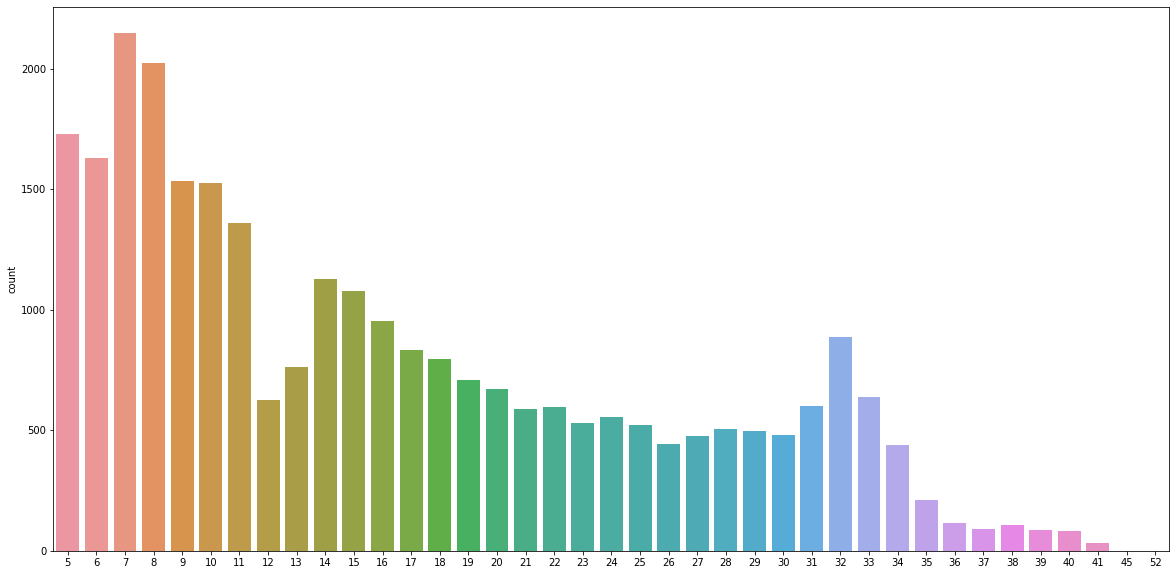

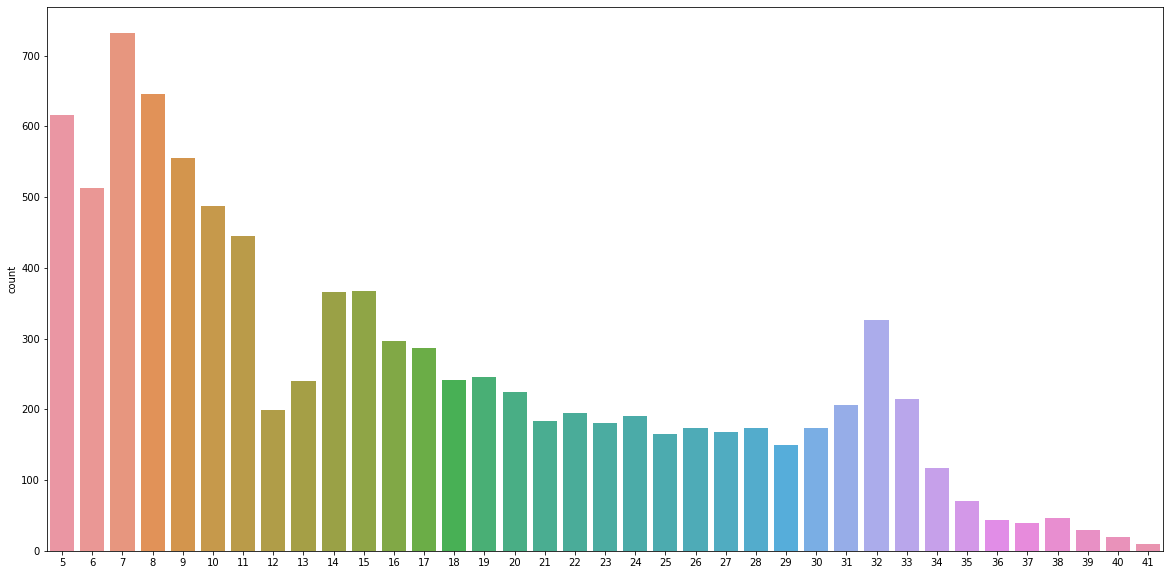

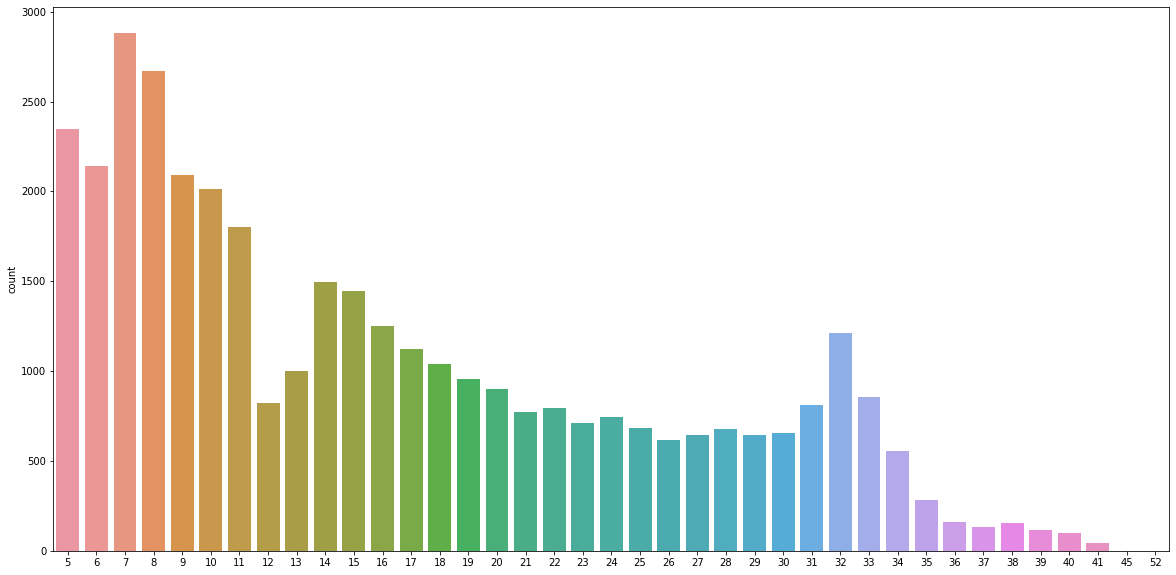

In [54]:
l = []
for i in range(len(train)):
    l.append(len(list(ast.literal_eval(train['PaymentsHistory'][i]))))
k = []
for i in range(len(test)):
    k.append(len(list(ast.literal_eval(test['PaymentsHistory'][i]))))
plt.figure(figsize=(20,10))
sns.countplot(l)
print(np.mean(l))
plt.figure(figsize=(20,10))
sns.countplot(k)
print(np.mean(k))
j = k + l 
plt.figure(figsize=(20,10))
sns.countplot(j)
print(np.mean(j))

In [55]:
%%time
df_train_imp = impute(train)
df_test_imp = impute(test)

0


KeyboardInterrupt: 

In [56]:
#np.save('seq_ewm_mavg_mstd_lag_train.npy', np.array(df_train_imp, dtype=object))
#np.save('seq_ewm_mavg_mstd_lag_test.npy', np.array(df_test_imp, dtype=object))# save

In [72]:
%%time
df_train_imp = np.load('../input/zindi-competition-notebook/df_train_imp.npy', allow_pickle=True)
df_test_imp = np.load('../input/zindi-competition-notebook/df_test_imp.npy', allow_pickle=True)

CPU times: user 17.3 s, sys: 66.2 ms, total: 17.4 s
Wall time: 17.4 s


In [58]:
%%time
df_train_imp = np.load('../input/zindi-competition-notebook/seq_ewm_mavg_mstd_lag_train.npy', allow_pickle=True)
df_test_imp = np.load('../input/zindi-competition-notebook/seq_ewm_mavg_mstd_lag_test.npy', allow_pickle=True)

CPU times: user 15.8 s, sys: 127 ms, total: 15.9 s
Wall time: 15.8 s


In [59]:
#MANUAL TIME SPLIT
'''y = []
for i in range(21000):
    y.append((mler.values[i,:]))
y_train = np.array(y)
y = []
for i in range(7007):
    y.append((mler.values[21000+i,:]))
y_test = np.array(y)
trainlist = df_train_imp[0:21000]
testlist = df_train_imp[21000:]'''

'y = []\nfor i in range(21000):\n    y.append((mler.values[i,:]))\ny_train = np.array(y)\ny = []\nfor i in range(7007):\n    y.append((mler.values[21000+i,:]))\ny_test = np.array(y)\ntrainlist = df_train_imp[0:21000]\ntestlist = df_train_imp[21000:]'

In [60]:
#ymean = np.mean(y,axis=1)
#ymean[ymean>5000]

In [73]:
y = []
for i in range(len(mler)):
    y.append((mler.values[i]))
from sklearn.model_selection import train_test_split
indices = np.arange(len(df_train_imp))
y_bc, _ = stats.boxcox(np.concatenate(y))
y_bc = np.reshape(y_bc,mler.shape)
trainlist, testlist, y_train, y_test, idx1, idx2 = train_test_split(df_train_imp,y_bc,indices,test_size=0.2,random_state=0, shuffle=True)

In [74]:
mm = MinMaxScaler()
maxlen=25
pad = 'pre'
X_train = tf.keras.preprocessing.sequence.pad_sequences(trainlist, maxlen=maxlen, padding=pad)
X_test = tf.keras.preprocessing.sequence.pad_sequences(testlist, maxlen=maxlen, padding=pad)
y_train = np.array(y_train)
y_test = np.array(y_test)

LOG TRANSFORM

**YENI SCALING**

In [75]:
scaler = RobustScaler() #StandardScaler()
train_data = X_train
num_instances, num_time_steps, num_features = train_data.shape
train_data = np.reshape(train_data,(-1, num_features))
train_data = scaler.fit_transform(train_data)
train_data = np.reshape(train_data,(num_instances, num_time_steps, num_features))
X_train = train_data
num_instances, num_time_steps, num_features = X_test.shape
X_test = scaler.transform(X_test.reshape((-1,num_features)))
X_test = np.reshape(X_test,(num_instances, num_time_steps, num_features))
y_train = y_train.reshape(y_train.shape[0],y_train.shape[1],1)
y_test = y_test.reshape(y_test.shape[0],y_test.shape[1],1)
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)
y_train = y_train.astype('float32')
X_train = X_train.astype('float32')
y_test = y_test.astype('float32')
X_test = X_test.astype('float32')

(22405, 25, 9) (22405, 6, 1) (5602, 25, 9) (5602, 6, 1)


CONT

18995	ID_8ZMJX9O x m6	226


42497	ID_984AG4Q x m6	1274

In [78]:
test_meta

,Deposit,AccessoryRate,RatePerUnit,DaysOnDeposit,Age,Term,TotalContractValue,rateTypeEntity,MainApplicantGender,Region,...,ExpectedTermDateday,ExpectedTermDatemonth,ExpectedTermDateyear,FirstPaymentDateday,FirstPaymentDatemonth,FirstPaymentDateyear,LastPaymentDateday,LastPaymentDatemonth,LastPaymentDateyear,Kmeans
0,2000,0.0,35,7,33,364,14740.0,0,1,0,...,7,12,2016,9,12,2015,24,5,2020,0
1,2000,0.0,35,7,38,364,14740.0,0,0,1,...,12,12,2016,14,12,2015,12,12,2016,0
2,2000,0.0,35,7,32,364,14740.0,0,1,1,...,4,12,2016,6,12,2015,22,7,2020,0
3,2000,0.0,35,7,42,364,14740.0,0,0,1,...,3,12,2016,4,12,2015,17,5,2017,0
4,2000,0.0,35,7,38,364,14740.0,0,0,1,...,9,12,2016,11,12,2015,11,2,2017,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9331,2400,0.0,50,3,33,240,14400.0,0,1,4,...,17,10,2020,20,2,2020,25,5,2021,0
9332,2400,0.0,50,3,36,240,14400.0,0,1,0,...,17,10,2020,20,2,2020,26,5,2021,0
9333,2400,0.0,50,3,26,240,14400.0,0,1,3,...,17,10,2020,20,2,2020,15,5,2021,0
9334,2400,0.0,50,3,26,240,14400.0,0,1,4,...,17,10,2020,20,2,2020,26,5,2021,0


In [77]:
train_meta = pd.merge(train[['ID']],train_meta_dmy,on='ID',how='left').drop(['ID'],1)
test_meta = pd.merge(test[['ID']],test_meta_dmy,on='ID',how='left').drop(['ID'],1)
x_train_meta = train_meta.loc[idx1]
x_test_meta = train_meta.loc[idx2]
scaler = StandardScaler()
train_meta_sc = pd.DataFrame(scaler.fit_transform(train_meta))
test_meta_sc = pd.DataFrame(scaler.transform(test_meta))

TRAIN WEIGHTS

In [79]:
mer = pd.concat([train_meta,np.mean(mler, axis=1)],1)

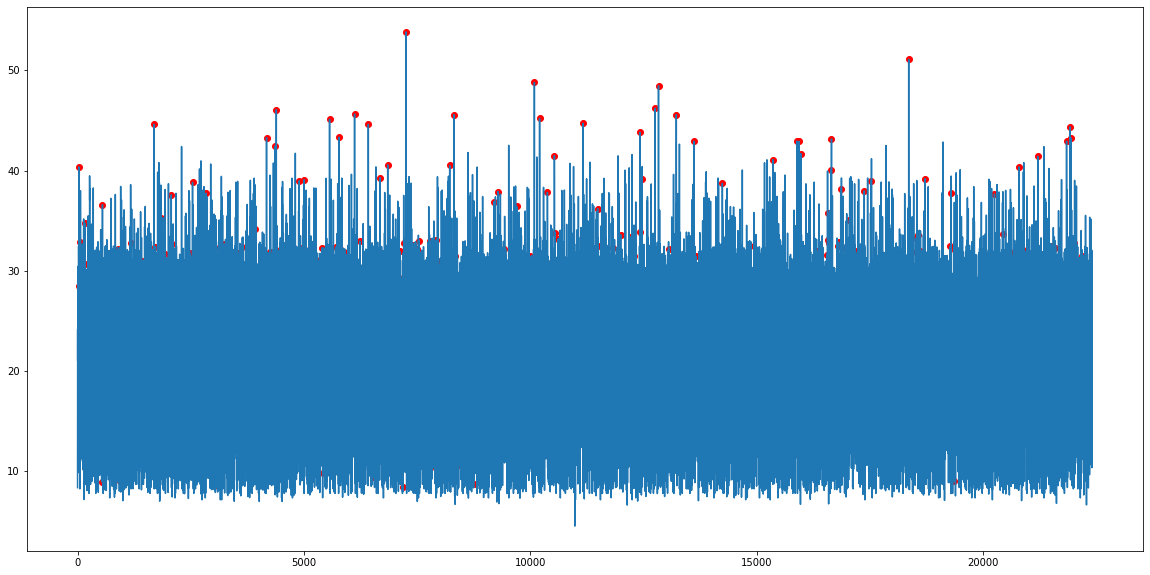

In [80]:
#swmatrix =  mer.iloc[np.where(mer[0]>4500)].drop(0,1)
swmatrix =  mer.iloc[np.where(mer[0]>3500)].drop(0,1)
swdf = []
for col in swmatrix.columns:
    swdf.append(swmatrix[col].unique())
ist = []
sums = 0
for i,col in enumerate(x_train_meta.columns):
    sums += sum(x_train_meta[col].isin(swdf[i]))
    #print(i,col,sum(x_train_meta[col].isin(swdf[i])),sums)
    ist.append(x_train_meta[col][x_train_meta[col].isin(swdf[i])].index.values)
comlist = ist[0]
for i in range(len(ist)-1):
    comlist = np.intersect1d(ist[i+1], comlist)
y_means = []
for i in range(len(y_train)):
    y_means.append(np.mean(y_train[i]))
y_means = np.array(y_means)
where = np.where(x_train_meta.index.isin(np.intersect1d(x_train_meta.index.values, comlist)))
#np.where((x_train_meta['rateTypeEntity']==0)&x_train_meta['RegistrationDatemonth'].isin([1,2,3,4])&(x_train_meta['Deposit']>=2500))
plt.figure(figsize=(20,10))
plt.scatter(where,y_means[where], color='red')
plt.plot(y_means)
train_sample_weight = np.ones(shape=(len(y_train),))
train_sample_weight[where] = y_means[where]/y_means[where].max()+10#1.5

TEST WEIGHTS

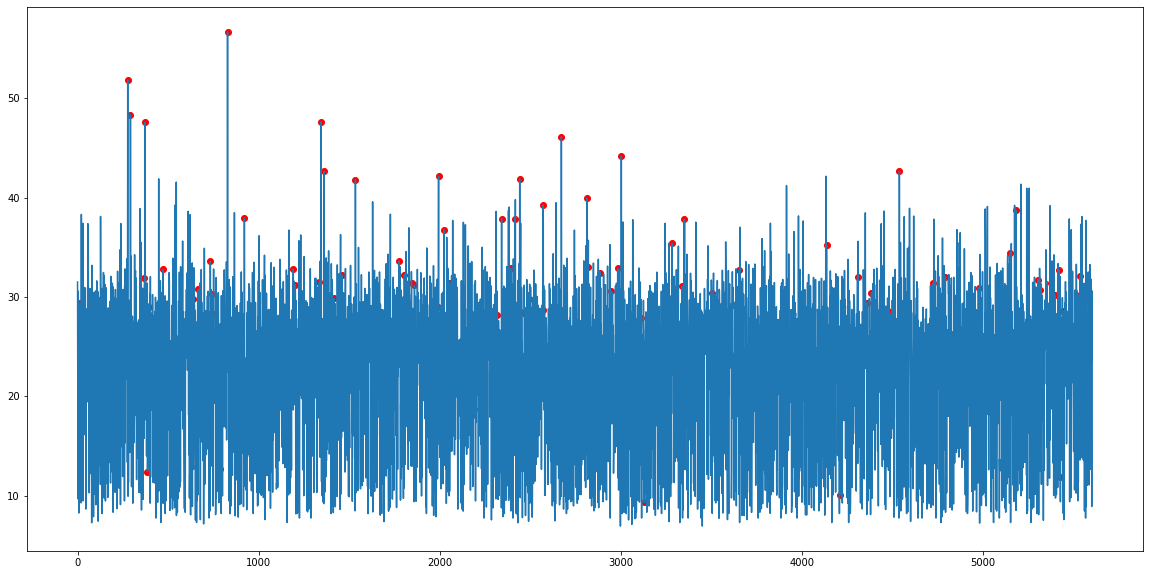

In [81]:
swmatrix =  mer.iloc[np.where(mer[0]>3500)].drop(0,1)
swdf = []
for col in swmatrix.columns:
    swdf.append(swmatrix[col].unique())
ist = []
sums = 0
for i,col in enumerate(x_test_meta.columns):
    sums += sum(x_test_meta[col].isin(swdf[i]))
    #print(i,col,sum(x_test_meta[col].isin(swdf[i])),sums)
    ist.append(x_test_meta[col][x_test_meta[col].isin(swdf[i])].index.values)
comlist = ist[0]
for i in range(len(ist)-1):
    comlist = np.intersect1d(ist[i+1], comlist)
y_means = []
for i in range(len(y_test)):
    y_means.append(np.mean(y_test[i]))
y_means = np.array(y_means)
where = np.where(x_test_meta.index.isin(np.intersect1d(x_test_meta.index.values, comlist)))
#np.where((x_test_meta['rateTypeEntity']==0)&x_test_meta['RegistrationDatemonth'].isin([1,2,3,4])&(x_test_meta['Deposit']>=2500))
plt.figure(figsize=(20,10))
plt.scatter(where,y_means[where], color='red')
plt.plot(y_means)
test_sample_weight = np.ones(shape=(len(y_test),))
test_sample_weight[where] = y_means[where]/y_means[where].max()+10

META PROCESS ANIMAL

In [69]:
def add_sct(df,cols):
    d = {}
    for col in cols:
        d[col+'sin'] = np.sin(df[col])*2*np.pi/(df[col].nunique())
        d[col+'cos'] = np.cos(df[col])*2*np.pi/(df[col].nunique())
        d[col+'tan'] = np.tan(df[col])*2*np.pi/(df[col].nunique())

    concat_data = pd.concat([df, pd.DataFrame(d)], axis=1)
    return concat_data.drop(cols,1)
def add_dmy(df,cols):
    d = {}
    for col in cols:
        d[col + 'day'] = df[col].dt.day
        d[col + 'month'] = df[col].dt.month
        d[col + 'year'] = df[col].dt.year
    concat_data = pd.concat([df,pd.DataFrame(d)],1)
    return concat_data.drop(cols,1)
def create_target(df: pd.DataFrame, window: int = 2):
    try:
        df = df.copy()

        df["ExpectedTermDate"] = pd.to_datetime(df["ExpectedTermDate"]) + pd.to_timedelta(pd.np.ceil(df.Term * window),
                                                                                          unit="D")
        df["LastPaymentDate"] = pd.to_datetime(df["LastPaymentDate"]).dt.tz_localize(None)

        targets = []

        for r in df.iterrows():
            r = r[1]
            target = ((100 * sum(
                ast.literal_eval(r.PaymentsHistory) + r[-6:].values.tolist()) // r.TotalContractValue) >= 60.) and (
                                 r.LastPaymentDate < r.ExpectedTermDate)
            targets.append(float(target))

        df["Target"] = targets

        del targets

        return df

    except Exception as ex:
        logging.error(msg=f'{ex}')

        return None

In [70]:
%%time
imputed_age = KNNImputer().fit_transform(metadata['Age'].values.reshape((-1,1)))
imputed_age = imputed_age.astype(int)
metadata['Age'] = imputed_age
newmeta = metadata.drop(['UpsellDate','AccessoryRate','SupplierName','PaymentMethod'],axis=1)
rateTypeEntitymap = {'DAILY':1,'WEEKLY':7,'MONTHLY':30}
newmeta['rateTypeEntity'] = newmeta['rateTypeEntity'].map(rateTypeEntitymap)
newmeta['RatePerUnit/RateType'] = newmeta['rateTypeEntity']/newmeta['RatePerUnit']
newmeta['Age_bins'] = LabelEncoder().fit_transform(pd.qcut(newmeta['Age'],3))
newmeta['Region'] = newmeta['Region'].fillna(newmeta['Region'].mode()[0])
newmeta['Town'] = newmeta['Town'].fillna(newmeta['Town'].mode()[0])
newmeta['Occupation'].apply(lambda x:1 if x in ('Farmer','Labourer','Driver/Motorbike Rider')
                             else (2 if x in('Teacher','Other') else 3))
train_sort = pd.merge(newmeta['ID'],pd.concat([train[['ID','PaymentsHistory']],
                                              test[['ID','PaymentsHistory']]]),on='ID',how='left')

CPU times: user 9.62 s, sys: 2.58 s, total: 12.2 s
Wall time: 11 s


In [ ]:
le = LabelEncoder()
wanted_cols = [col for col in newmeta.columns if 'date' not in col.lower()
               and newmeta[col].dtypes != int and newmeta[col].dtypes != float]
wanted_cols.remove('ID')
d = {}
for col in wanted_cols:
    print(col)
    d[col] = le.fit_transform(newmeta[col])
lencoded = pd.DataFrame(d)
meta_encoded = pd.concat([newmeta.drop(wanted_cols,1),lencoded],1)
date_cols = [col for col in newmeta.columns if 'date' in col.lower()]
for col in date_cols:
    meta_encoded[col] = pd.to_datetime(meta_encoded[col])
all_id = meta_encoded['ID']
train_id = all_id.isin(train['ID'])
train_meta = meta_encoded.loc[train_id,:]
train_m1 = train[['ID','m1','m2','m3','m4','m5','m6']]
train_merge = pd.merge(train_meta,train_m1,on='ID')
merged = pd.merge(left=metadata, right=pd.concat(objs=[train, test]).fillna(value=0.), on="ID")
target = create_target(merged, window=4)
train_merge = pd.merge(train_merge,target[['ID','Target']],on='ID',how='inner')
train_merge_dmy = add_dmy(train_merge,['RegistrationDate','ExpectedTermDate','FirstPaymentDate','LastPaymentDate'])
kmean = KMeans(n_clusters=3, random_state=7).fit(train_merge_dmy.drop(['ID','m1','m2','m3','m4','m5','m6'],1))
train_merge_dmy['Kmeans'] = kmean.labels_
train_merge_trig = add_sct(train_merge_dmy,[col for col in train_merge_dmy.columns if 'date' in col.lower()])
kmean = KMeans(n_clusters=3, random_state=7).fit(train_merge_trig.drop(['ID','m1','m2','m3','m4','m5','m6'],1))
train_merge_trig['Kmeans'] = kmean.labels_
'''DUMMIES'''
cat_var = ['rateTypeEntity','Age_bins','MainApplicantGender','Region','Town','Occupation','Target','Kmeans'] + list(
    [c for c in train_merge_dmy.columns if 'date' in c.lower()])
#dum = pd.get_dummies(data=train_merge_dmy, columns=cat_var)
#eski = train_merge_dmy.copy()
#train_merge_dmy = dum
test_id = ~all_id.isin(train['ID'])
test_meta = meta_encoded.loc[test_id,:]
#test_meta['Last-FirstPayment'] = (test_meta['LastPaymentDate']-test_meta['FirstPaymentDate']).astype(str).apply(
#    lambda x:x[0:4]).astype(int)
test_meta = pd.merge(test_meta,target[['ID','Target']],on='ID',how='inner')
test_meta_dmy = add_dmy(test_meta,['RegistrationDate','ExpectedTermDate','FirstPaymentDate','LastPaymentDate'])
kmean = KMeans(n_clusters=3, random_state=7).fit(test_meta_dmy.drop(['ID'],1))
test_meta_dmy['Kmeans'] = kmean.labels_
test_meta_trig = add_sct(test_meta_dmy,[col for col in test_meta_dmy.iloc[:,0:-7].columns if 'date' in col.lower()])
kmean = KMeans(n_clusters=3, random_state=7).fit(test_meta_trig.drop(['ID'],1))
test_meta_trig['Kmeans'] = kmean.labels_
test_meta_dmy = pd.get_dummies(data=test_meta_dmy, columns=cat_var)

train_dates = train_merge[date_cols].apply(lambda x:x.dt.date)
test_dates = test_meta[date_cols].apply(lambda x:x.dt.date)
def f1(dates):
    new_df = pd.DataFrame()
    for p in combinations_with_replacement(dates.columns,2):
            title = p
            new_df[title] = dates[p[0]]-dates[p[1]]
    return new_df

train_date_diff = f1(train_dates)
test_date_diff = f1(test_dates)
differences = train_date_diff.drop([c for c in train_date_diff.columns if np.sum(train_date_diff[c].astype(int))==0],1)\
    .apply(lambda x:x.dt.days)
train_merge_dmy = pd.concat([train_merge_dmy,differences],1)
test_differences = test_date_diff.drop([c for c in test_date_diff.columns if np.sum(test_date_diff[c].astype(int))==0],1)\
    .apply(lambda x:x.dt.days)
test_meta_dmy = pd.concat([test_meta_dmy,test_differences],1)

COMB MODEL

In [82]:
%%time
data = train_meta_sc#pd.DataFrame(train_meta_ts_sc)
d = 0.25
r = 1e-5
model = Sequential()
pdic = {}
pdic['losses'] = [tf.keras.losses.Huber(delta=1.0, reduction="auto", name="huber_loss"),tf.keras.losses.LogCosh(),'mse',
                 tf.keras.losses.MeanSquaredLogarithmicError()]
pdic['activations'] = ['relu',tf.keras.layers.LeakyReLU(),'softplus','sigmoid']
activation = pdic['activations'][1]
#loss = pdic['losses'][1]
n = 50
model = Sequential()
model.add(((LSTM(10*n,input_shape=(None,X_train.shape[-1]), return_sequences=True, activity_regularizer=tf.keras.regularizers.l2(r)))))
model.add(BatchNormalization())
model.add(Dropout(d))
model.add(((LSTM(7*n, return_sequences=True,activity_regularizer=tf.keras.regularizers.l2(r),activation=activation))))
model.add(BatchNormalization())
model.add(Dropout(d))
model.add(((LSTM(5*n, return_sequences=False,activity_regularizer=tf.keras.regularizers.l2(r),activation=activation))))
model.add(BatchNormalization())
model.add(Dropout(d))
model.add(Dense(3*n,activity_regularizer=tf.keras.regularizers.l2(1e-5),activation=activation))
model.add(BatchNormalization())
model.add(Dropout(d))
##
model2 = Sequential()
model2.add(Dense(300,activation = activation,input_shape=(data.shape[1],)))
model2.add(BatchNormalization())
model2.add(Dropout(d))
model2.add(Dense(100,activation = activation)) 
model2.add(BatchNormalization())
model2.add(Dropout(d))
merged = Concatenate()([model.output,model2.output])
z = Dense(100,activation='relu')(merged)
z = Dense(6,activation='relu')(z)
model = keras.Model(inputs=[model.input, model2.input], outputs=z)
model.compile(loss='mse',
              optimizer=keras.optimizers.Adam(),  metrics=[rmse],loss_weights = [0.3,0.7])
loss_history = History()
lr_rate = LearningRateScheduler(exp_decay)
e_s = tf.keras.callbacks.EarlyStopping(monitor='val_rmse', patience=5)
callbacks_list = [loss_history, e_s, lr_rate]
history = model.fit([X_train,data.iloc[idx1]],y_train, epochs=20, batch_size=100, verbose=1, 
                    callbacks=[callbacks_list], validation_split=0.2, sample_weight=train_sample_weight)

Epoch 1/20
180/180 [==============================] - 23s 103ms/step - loss: 113.1367 - rmse: 16.2453 - val_loss: 38.1689 - val_rmse: 9.3111
Epoch 2/20
180/180 [==============================] - 18s 102ms/step - loss: 197.1776 - rmse: 8.7183 - val_loss: 95.3467 - val_rmse: 5.8000
Epoch 3/20
180/180 [==============================] - 17s 93ms/step - loss: 910.1969 - rmse: 6.1288 - val_loss: 36.5692 - val_rmse: 6.0667
Epoch 4/20
180/180 [==============================] - 18s 99ms/step - loss: 251.5393 - rmse: 5.8856 - val_loss: 81.8359 - val_rmse: 5.7333
Epoch 5/20
180/180 [==============================] - 18s 97ms/step - loss: 71.0737 - rmse: 5.6464 - val_loss: 50.6995 - val_rmse: 5.6667
Epoch 6/20
180/180 [==============================] - 17s 97ms/step - loss: 49.7283 - rmse: 5.7556 - val_loss: 45.1642 - val_rmse: 5.4667
Epoch 7/20
180/180 [==============================] - 18s 99ms/step - loss: 44.6615 - rmse: 5.6832 - val_loss: 42.9230 - val_rmse: 5.4889
Epoch 8/20
180/180 [=======

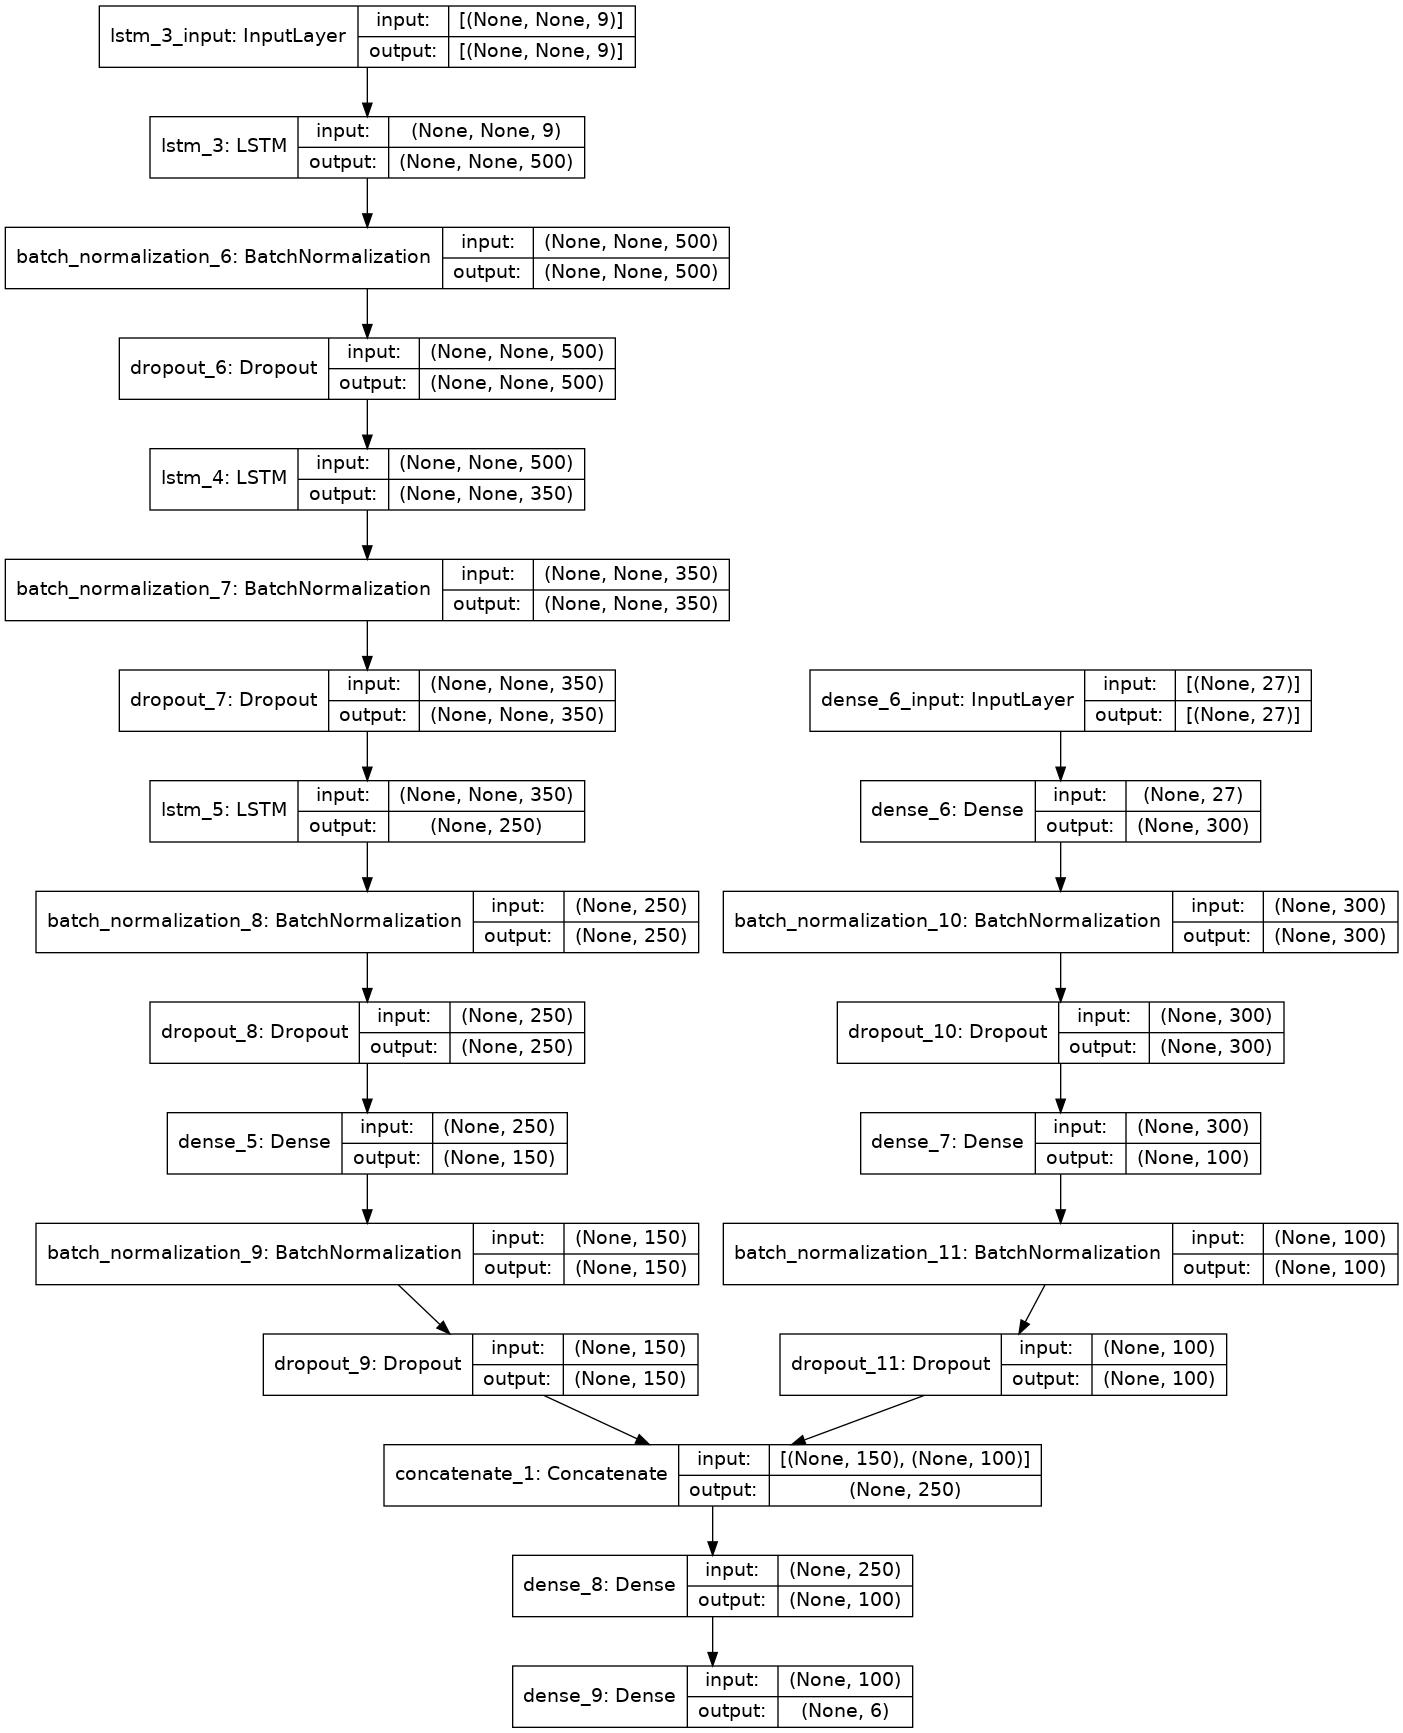

In [83]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [84]:
pred_bc = model.predict([X_test,data.iloc[idx2]])
pred = inv_boxcox(pred_bc, _)
pred = pred.astype(int)
pred = np.clip(pred,0,np.inf)
pd.DataFrame(pred).value_counts()

0       1       2       3       4       5     
3682.0  3090.0  3367.0  3381.0  3339.0  4003.0    1
484.0   444.0   403.0   437.0   417.0   352.0     1
482.0   457.0   447.0   450.0   458.0   487.0     1
        496.0   504.0   456.0   473.0   287.0     1
483.0   450.0   449.0   459.0   454.0   516.0     1
                                                 ..
892.0   937.0   893.0   982.0   960.0   893.0     1
        940.0   900.0   971.0   958.0   663.0     1
893.0   753.0   847.0   837.0   828.0   969.0     1
        757.0   851.0   839.0   844.0   1054.0    1
66.0    74.0    67.0    82.0    70.0    47.0      1
Length: 5602, dtype: int64

In [85]:
def a(x):
    return inv_boxcox(x,_)

**--------------------PLOT--------------------**

769.0439676963855


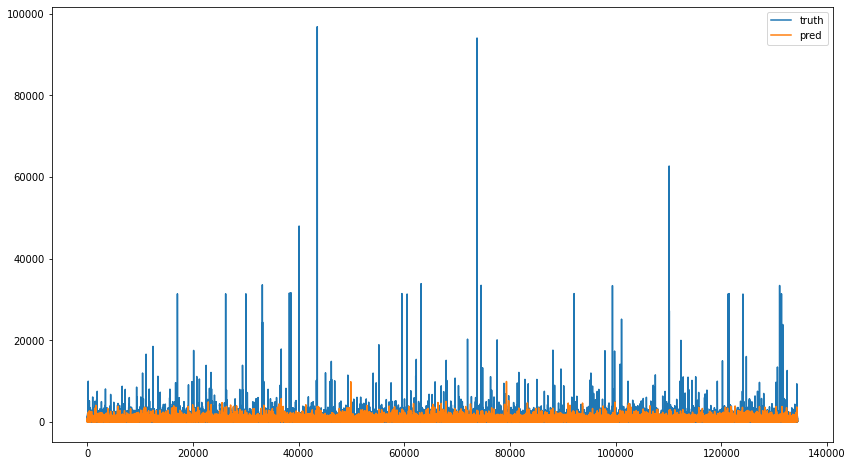

In [86]:
pr = a(model.predict([X_train,data.iloc[idx1]]))
pr = pr.astype(int)
truth = a(y_train.reshape(pr.shape))
print(np.sqrt(mean_squared_error(truth,pr)))
plt.figure(figsize=(14,8))
plt.plot(truth.ravel(), label='truth')
plt.plot(pr.ravel(), label='pred')
plt.legend()

In [87]:
pd.DataFrame(pr).value_counts()

0    1    2    3    4    5  
127  129  104  104  94   55     3
88   78   71   68   75   66     2
91   75   76   71   76   73     2
92   80   73   70   78   71     2
119  118  95   98   89   62     2
                               ..
892  912  884  970  945  940    1
     917  889  957  944  592    1
     937  887  949  912  581    1
     938  923  946  944  333    1
63   51   43   61   41   59     1
Length: 22383, dtype: int64

In [ ]:
pr = a(model.predict([X_test,data.iloc[idx2]]))
pr = pr.astype(int)
truth = a(y_test.reshape(pr.shape))
print(np.sqrt(mean_squared_error(truth,pr)))
plt.figure(figsize=(14,8))
plt.plot(truth.ravel(), label='truth')
plt.plot(pr.ravel(), label='pred')
plt.legend()

In [88]:
pd.DataFrame(pr).value_counts()

0    1    2    3    4    5  
127  129  104  104  94   55     3
88   78   71   68   75   66     2
91   75   76   71   76   73     2
92   80   73   70   78   71     2
119  118  95   98   89   62     2
                               ..
892  912  884  970  945  940    1
     917  889  957  944  592    1
     937  887  949  912  581    1
     938  923  946  944  333    1
63   51   43   61   41   59     1
Length: 22383, dtype: int64

<AxesSubplot:>

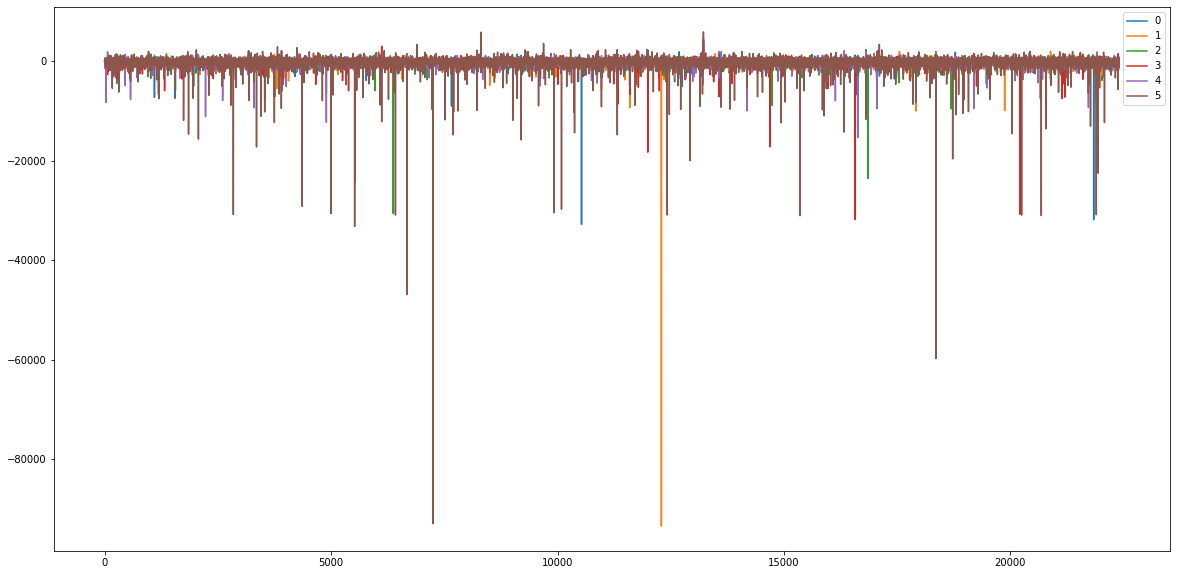

In [89]:
pd.DataFrame(pr-truth).plot(figsize=(20,10))

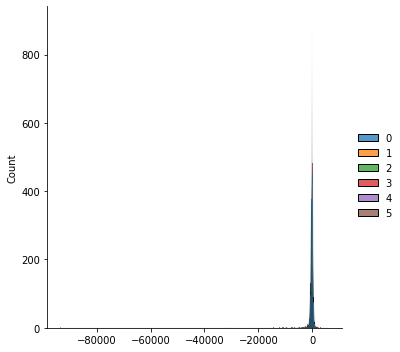

In [90]:
sns.displot(pr-truth)

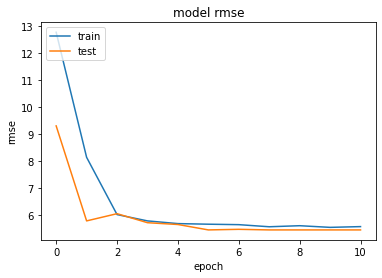

In [92]:
plt.plot(history.history['rmse'])
plt.plot(history.history['val_rmse'])
plt.title('model rmse')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

SUBMISSION

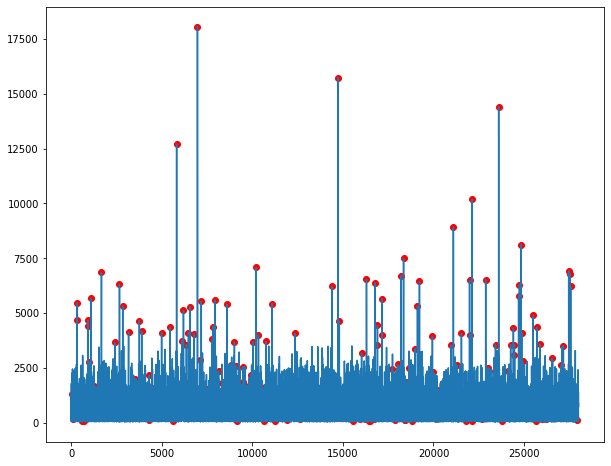

In [93]:
alltrain = tf.keras.preprocessing.sequence.pad_sequences(df_train_imp, maxlen=maxlen, padding=pad)

ally = []
for i in range(len(train)):
    ally.append((mler.values[i,:]))
ally = np.array(ally)

swmatrix =  mer.iloc[np.where(mer[0]>3500)].drop(0,1)
swdf = []
for col in swmatrix.columns:
    swdf.append(swmatrix[col].unique())
ist = []
sums = 0
for i,col in enumerate(train_meta.columns):
    sums += sum(train_meta[col].isin(swdf[i]))
    #print(i,col,sum(x_test_meta[col].isin(swdf[i])),sums)
    ist.append(train_meta[col][train_meta[col].isin(swdf[i])].index.values)
comlist = ist[0]
for i in range(len(ist)-1):
    comlist = np.intersect1d(ist[i+1], comlist)
y_means = []
for i in range(len(ally)):
    y_means.append(np.mean(ally[i]))
y_means = np.array(y_means)
where = np.where(train_meta.index.isin(np.intersect1d(train_meta.index.values, comlist)))
#np.where((x_test_meta['rateTypeEntity']==0)&x_test_meta['RegistrationDatemonth'].isin([1,2,3,4])&(x_test_meta['Deposit']>=2500))
plt.figure(figsize=(10,8))
plt.scatter(where,y_means[where], color='red')
plt.plot(y_means)
sample_weight = np.ones(shape=(len(ally),))
sample_weight[where] = y_means[where]/y_means[where].max()+10

In [94]:
alltrain = tf.keras.preprocessing.sequence.pad_sequences(df_train_imp, maxlen=maxlen, padding=pad)

ally = []
for i in range(len(train)):
    ally.append((mler.values[i,:]))
ally = np.array(ally)

scaler = StandardScaler()
num_instances, num_time_steps, num_features = alltrain.shape
alltrain = np.reshape(alltrain,(-1, num_features))
alltrain = scaler.fit_transform(alltrain)
alltrain = np.reshape(alltrain,(num_instances, num_time_steps, num_features))

ally = ally.reshape(ally.shape[0],ally.shape[1],1)
alltrain = alltrain.astype('float32')
ally = ally.astype('float32')
##
ally_bc = boxcox(ally.ravel(),_)
ally_bc = ally_bc.reshape((ally.shape[0],ally.shape[1],1))

history = model.fit([alltrain,train_meta],ally_bc, epochs=3, batch_size=50, verbose=1,callbacks=[callbacks_list],sample_weight=sample_weight)

sub = tf.keras.preprocessing.sequence.pad_sequences(df_test_imp, maxlen=maxlen, padding=pad)
num_instances, num_time_steps, num_features = sub.shape
sub = scaler.transform(sub.reshape((-1,num_features)))
sub = np.reshape(sub,(num_instances, num_time_steps, num_features))

pred = model.predict([sub,test_meta])
pred = inv_boxcox(pred,_)
pred = pred.astype(int)
pred = np.clip(pred, 40, np.inf)

pd.DataFrame(pred).value_counts()

Epoch 1/3
561/561 [==============================] - 53s 95ms/step - loss: 53.0551 - rmse: 7.9608
Epoch 2/3
561/561 [==============================] - 52s 93ms/step - loss: 49.0998 - rmse: 7.3012
Epoch 3/3
561/561 [==============================] - 53s 94ms/step - loss: 48.0887 - rmse: 7.1337


0      1      2      3      4      5    
70.0   72.0   61.0   79.0   80.0   66.0     13
72.0   72.0   61.0   79.0   81.0   68.0     12
71.0   72.0   61.0   79.0   81.0   67.0     11
                            80.0   66.0     11
70.0   72.0   61.0   79.0   80.0   65.0      9
                                            ..
691.0  647.0  616.0  642.0  633.0  423.0     1
                                   425.0     1
                     643.0  633.0  425.0     1
                            634.0  426.0     1
68.0   71.0   61.0   77.0   78.0   64.0      1
Length: 8696, dtype: int64

In [95]:
submission = pd.read_csv('../input/zindi-competition-notebook/SampleSubmission.csv')
submission['Target'] = pred.ravel()
submission.to_csv('submission.csv', index=False)

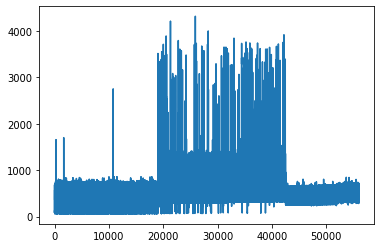

In [96]:
plt.plot(pred.ravel())